In [68]:
# Main import block 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import random
import itertools
import time
from sklearn.calibration import Parallel, delayed
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import clone

In [69]:

# Import data and show shapes
try:
    train_df = pd.read_csv('train_motion_data.csv')
    test_df = pd.read_csv('test_motion_data.csv')
    print("Train and test data loaded successfully.")
    print(f"Training data shape: {train_df.shape}")
    print(f"Testing data shape: {test_df.shape}\n")
except FileNotFoundError:
    print("Error: Make sure 'train_motion_data.csv' and 'test_motion_data.csv' are in the same directory.")
    exit()

train_df

print(f"Original shape: {train_df.shape}")

Train and test data loaded successfully.
Training data shape: (3644, 8)
Testing data shape: (3084, 8)

Original shape: (3644, 8)


As we can see, our training and testing data is of a similar size which will be useful when predicting our models and measuring accuracy. 

In [70]:
# Define features (X) and target (y)
features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
target = 'Class'

# Get train and test subsets 
X_train = train_df[features]
y_train_labels = train_df[target]
X_test = test_df[features]
y_test_labels = test_df[target]

# Encode labels into numbers that can be processed by various ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# scale X training data only to ensure data is within similar values 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now All of our data is scaled, encoded and ready to use! Time to start testing different models!

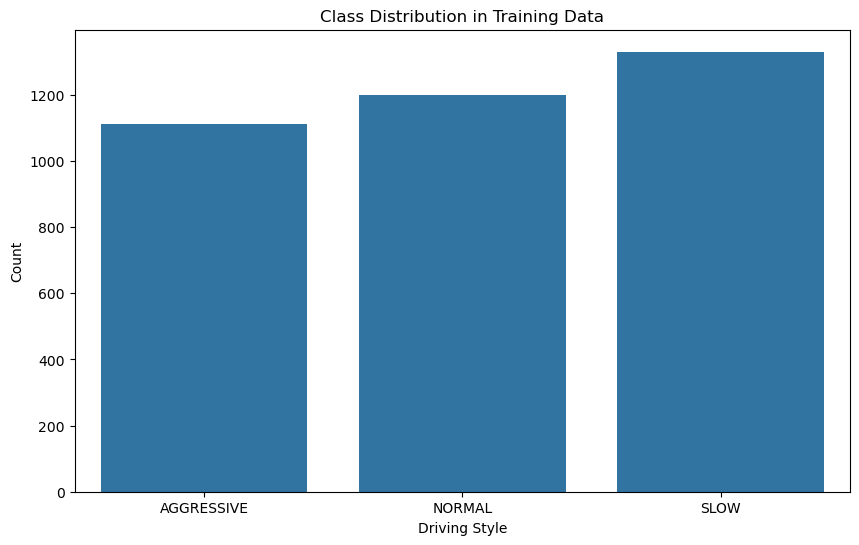

In [71]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_labels, order=le.classes_)
plt.title('Class Distribution in Training Data')
plt.xlabel('Driving Style')
plt.ylabel('Count')
plt.show()

In [72]:
# create result grid to store classification results 
results = {}


def run_grid_search(model, param_grid, X_train, y_train, X_test, y_test):


    
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"Testing {len(param_combinations)} candidate models...")
    print("-" * 80)

    # Trains a single model and evaluates it on the test set.
    def evaluate_candidate(params, X_train, y_train, X_test, y_test):
        # model = RandomForestClassifier(random_state=42, n_jobs=1, **params)

        candidate_model = clone(model)
        candidate_model.set_params(**params)
        
        # Train
        candidate_model.fit(X_train, y_train)
        
        # Predict
        predictions = candidate_model.predict(X_test)
        acc = accuracy_score(y_test, predictions)
        
        # Return dictionary of results
        result = params.copy()
        result['test_accuracy'] = acc
        return result
    
    start_time = time.time()


    results = Parallel(n_jobs=-1, verbose=1)(
    delayed(evaluate_candidate)(params, X_train, y_train, X_test, y_test)
    for params in param_combinations
    )

    end_time = time.time()
    print(f"\nGrid Search completed in {end_time - start_time:.2f} seconds.")
    time.sleep(1)

    results_df = pd.DataFrame(results)

    # Sort by Test Accuracy (Descending)
    best_model = results_df.sort_values(by='test_accuracy', ascending=False).iloc[0]

    print("\n" + "="*40)
    print("       WINNING MODEL FOUND")
    print("="*40)
    print(f"Best Test Accuracy: {best_model['test_accuracy']:.4f}")
    print("-" * 40)
    for key, value in best_model.items():
        if key == 'test_accuracy':
            continue
        print(f"{key}: {value}")
    print("-" * 40)

    best_params = best_model.drop('test_accuracy').to_dict()

    best_params = {
    k: int(v) if isinstance(v, float) and v.is_integer() else v 
    for k, v in best_params.items()
    }
    
    # 2. Create a fresh model with the winning settings
    final_model = clone(model)
    final_model.set_params(**best_params)
    
    # 3. Retrain on the full training set
    final_model.fit(X_train, y_train)
    
    # 4. Predict and Report
    final_predictions = final_model.predict(X_test)


    model_name = type(model).__name__
    print("\n" + "="*60)
    print("                     CLASSIFICATION REPORT")
    print("="*60)
    report_str = classification_report(y_test, final_predictions)
    report_dict = classification_report(y_test, final_predictions, output_dict=True)
    print(report_str)

    return model_name, report_dict 

    

In [ ]:

# Graident Boosting Classifier Test: 
gb_model = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 200],  # Number of boosting stages (trees)
    'learning_rate': [0.01, 0.2],  # Step size shrinkage to prevent overfitting
    'max_depth': [3, 4],  # Maximum depth of the individual regression estimators
    'subsample': [0.7],  # Fraction of samples used for fitting the individual base learners
    'min_samples_split': [2, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt']  # Number of features to consider when looking for the best split
}

print("RUNNING GRID SEARCH ON GRAIDENT BOOSTING CLASSIFIER MODEL")
name, report = run_grid_search(gb_model,param_grid,X_train,y_train,X_test,y_test)

results[name] = report

RUNNING GRID SEARCH ON GRAIDENT BOOSTING CLASSIFIER MODEL
Testing 32 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    3.1s finished



Grid Search completed in 3.09 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4724
----------------------------------------
n_estimators: 100
learning_rate: 0.01
max_depth: 4
subsample: 0.7
min_samples_split: 10
min_samples_leaf: 4
max_features: sqrt
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.48      0.35      0.41       814
           1       0.32      0.05      0.09       997
           2       0.47      0.86      0.61      1273

    accuracy                           0.46      3084
   macro avg       0.42      0.42      0.37      3084
weighted avg       0.43      0.46      0.39      3084



In [74]:
# Bagging Classifier Test: 
from sklearn.ensemble import BaggingClassifier

bag_model = BaggingClassifier()

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap_features': [True, False]
}

print("RUNNING GRID SEARCH ON BAGGING CLASSIFER MODEL")
name, report = run_grid_search(bag_model,param_grid,X_train,y_train,X_test,y_test)

results[name] = report

RUNNING GRID SEARCH ON BAGGING CLASSIFER MODEL
Testing 54 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    3.1s finished



Grid Search completed in 3.11 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4248
----------------------------------------
n_estimators: 100
max_samples: 1.0
max_features: 1.0
bootstrap_features: True
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       814
           1       0.32      1.00      0.49       997
           2       0.00      0.00      0.00      1273

    accuracy                           0.32      3084
   macro avg       0.11      0.33      0.16      3084
weighted avg       0.10      0.32      0.16      3084



/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/j

In [57]:
# Hist Graident Boosting Classifier Test: 

from sklearn.ensemble import HistGradientBoostingClassifier

hgb_model = HistGradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_leaf_nodes': [20, 31, 50, 100],
    'max_iter': [100, 200, 500],
    'l2_regularization': [0.0, 0.1, 1.0],
    'max_bins': [63, 127, 255]
}

print("RUNNING GRID SEARCH ON HIST GRAIDENT BOOSTING CLASSIFIER MODEL")
name, report = run_grid_search(hgb_model,param_grid,X_train,y_train,X_test,y_test)
results[name] = report

RUNNING GRID SEARCH ON HIST GRAIDENT BOOSTING CLASSIFIER MODEL
Testing 432 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   41.3s finished



Grid Search completed in 41.32 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4582
----------------------------------------
learning_rate: 0.01
max_leaf_nodes: 20.0
max_iter: 100.0
l2_regularization: 0.0
max_bins: 255.0
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.47      0.41      0.44       814
           1       0.35      0.17      0.23       997
           2       0.48      0.71      0.58      1273

    accuracy                           0.46      3084
   macro avg       0.43      0.43      0.41      3084
weighted avg       0.44      0.46      0.43      3084



In [ ]:

from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(50, 50), (100), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.05],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 300]
}

print("RUNNING GRID SEARCH ON HIST GRAIDENT BOOSTING CLASSIFIER MODEL")
name, report = run_grid_search(mlp_model,param_grid,X_train,y_train,X_test,y_test)
results[name] = report

RUNNING GRID SEARCH ON HIST GRAIDENT BOOSTING CLASSIFIER MODEL
Testing 96 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jcshavel/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opt


Grid Search completed in 20.16 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4608
----------------------------------------
hidden_layer_sizes: (100,)
activation: tanh
solver: sgd
alpha: 0.05
learning_rate_init: 0.001
max_iter: 200
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.49      0.27      0.34       814
           1       0.36      0.11      0.17       997
           2       0.46      0.85      0.60      1273

    accuracy                           0.45      3084
   macro avg       0.44      0.41      0.37      3084
weighted avg       0.43      0.45      0.39      3084



In [76]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

print("RUNNING GRID SEARCH ON ADA BOOST CLASSIFIER MODEL")
name, report = run_grid_search(ada_model,param_grid,X_train,y_train,X_test,y_test)
results[name] = report

RUNNING GRID SEARCH ON ADA BOOST CLASSIFIER MODEL
Testing 15 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.5s finished



Grid Search completed in 0.54 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4640
----------------------------------------
n_estimators: 100.0
learning_rate: 1.0
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.45      0.39      0.42       814
           1       0.30      0.02      0.03       997
           2       0.47      0.86      0.61      1273

    accuracy                           0.46      3084
   macro avg       0.41      0.42      0.35      3084
weighted avg       0.41      0.46      0.37      3084



As we can see, our accuracy hovers around 40%, with f1 scores and precision that is not much better. Why is this? Well, it is seemingly quite difficult to not overfit our data and at the same time get good idea of the trend of the testing data. To combat this we can try a sliding window technique. We will loop through our dataset, looking at values from n to n+window_size. For each of these rows inside the window, we will calculate mean, standard deviation, min and max for each feature. This will allow us to see more trends and hopefully create a more accurate model. 

In [103]:
WINDOW_SIZE = 150

def create_time_series_features(df, feature_cols, window_size):
    """
    Creates time-series features based on a rolling window.
    """
    df_sorted = df.sort_values(by=timestamp_col).copy()

    df_out = df_sorted[[timestamp_col, target_col]].copy()

    for col in feature_cols:
        # .rolling() creates the window object.
        # We then apply aggregate functions like .mean(), .std(), etc.
        df_out[f'{col}_mean_{window_size}'] = df_sorted[col].rolling(window=window_size).mean()
        df_out[f'{col}_std_{window_size}'] = df_sorted[col].rolling(window=window_size).std()
        df_out[f'{col}_max_{window_size}'] = df_sorted[col].rolling(window=window_size).max()
        df_out[f'{col}_min_{window_size}'] = df_sorted[col].rolling(window=window_size).min()

    df_out = df_out.dropna()

    return df_out

feature_cols = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
target_col = 'Class'
timestamp_col = 'Timestamp'

df_train_engineered = create_time_series_features(train_df, feature_cols, WINDOW_SIZE)
df_test_engineered = create_time_series_features(test_df,feature_cols, WINDOW_SIZE)

# Define features (X) and target (y)
features = df_train_engineered.columns.to_list();
features.remove('Class')
target = 'Class'

# Get train and test subsets 
X_train = df_train_engineered[features]
y_train_labels = df_train_engineered[target]
X_test = df_test_engineered[features]
y_test_labels = df_test_engineered[target]

# Encode labels into numbers that can be processed by various ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# scale X training data only to ensure data is within similar values 
scaler = StandardScaler()
X_train_eng = scaler.fit_transform(X_train)
X_test_eng = scaler.transform(X_test)



In [ ]:
# Try random forest with new 'eng' engineered values 

rf_model = RandomForestClassifier(random_state=42)  

rf_param_grid_regularized = {
    'n_estimators': [710,723,720,700,709],
    'max_depth': [1,2,4,8],
    'min_samples_leaf': [730,734,736,700],
    'min_samples_split': [0.1,0.5,1.0,2],
    'criterion': ['gini'],
    'max_features': ['sqrt']
}

print("RUNNING GRID SEARCH ON RANDOM FOREST CLASSIFIER MODEL")
name, report = run_grid_search(rf_model,rf_param_grid_regularized,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report


RUNNING GRID SEARCH ON RANDOM FOREST CLASSIFIER MODEL
Testing 320 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   18.6s finished



Grid Search completed in 18.58 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.7019
----------------------------------------
n_estimators: 710
max_depth: 4
min_samples_leaf: 734
min_samples_split: 2.0
criterion: gini
max_features: sqrt
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.63      0.97      0.76       665
           1       0.69      0.50      0.58       997
           2       0.77      0.72      0.75      1273

    accuracy                           0.70      2935
   macro avg       0.70      0.73      0.70      2935
weighted avg       0.71      0.70      0.69      2935



In [118]:

# rerun gradient boosting model to see if we get better results
gb_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],  # Number of boosting stages (trees)
    'learning_rate': [0.1, 0.2],  # Step size shrinkage to prevent overfitting
    'max_depth': [3, 4],  # Maximum depth of the individual regression estimators
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples used for fitting the individual base learners
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

name, report = run_grid_search(gb_model,param_grid,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report



Testing 648 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.5s


KeyboardInterrupt: 

In [129]:
# rerun bagging to see if we get better results
from sklearn.ensemble import BaggingClassifier

bag_model = BaggingClassifier()

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.75, 1.0,50],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap_features': [True, False]
}

print("RUNNING GRID SEARCH ON BAGGING CLASSIFER MODEL")
name, report = run_grid_search(bag_model,param_grid,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report



RUNNING GRID SEARCH ON BAGGING CLASSIFER MODEL
Testing 72 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.7s finished



Grid Search completed in 1.68 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.6279
----------------------------------------
n_estimators: 50
max_samples: 0.5
max_features: 0.5
bootstrap_features: True
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.87      0.58      0.70       665
           1       0.38      0.94      0.54       997
           2       0.94      0.03      0.05      1273

    accuracy                           0.46      2935
   macro avg       0.73      0.52      0.43      2935
weighted avg       0.73      0.46      0.36      2935



{'GradientBoostingClassifier': {'0': {'precision': 0.4806070826306914,
   'recall': 0.3501228501228501,
   'f1-score': 0.4051172707889126,
   'support': 814.0},
  '1': {'precision': 0.32335329341317365,
   'recall': 0.05416248746238716,
   'f1-score': 0.09278350515463918,
   'support': 997.0},
  '2': {'precision': 0.47074010327022375,
   'recall': 0.8593872741555381,
   'f1-score': 0.608284681679177,
   'support': 1273.0},
  'accuracy': 0.4646562905317769,
  'macro avg': {'precision': 0.4249001597713629,
   'recall': 0.4212242039135918,
   'f1-score': 0.36872848587424295,
   'support': 3084.0},
  'weighted avg': {'precision': 0.42569700073194283,
   'recall': 0.4646562905317769,
   'f1-score': 0.3880081105184639,
   'support': 3084.0}},
 'BaggingClassifier': {'0': {'precision': 0.0,
   'recall': 0.0,
   'f1-score': 0.0,
   'support': 814.0},
  '1': {'precision': 0.3232814526588846,
   'recall': 1.0,
   'f1-score': 0.4886057338887528,
   'support': 997.0},
  '2': {'precision': 0.0, 'rec